<a href="https://colab.research.google.com/github/GregoireMichelDeletie/Test2/blob/main/U-Net_exercises/pytorch/3_unet2d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a U-net

The [U-net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) is a very popular model architecture for segmentation in bioimage analysis.
Here, we will train a 2D U-net for nuclei segmentation, using data from the [Kaggle Nucleus Segmentation challenge](https://www.kaggle.com/c/data-science-bowl-2018).

## Downloading the data - Colab


In [12]:
# Uncomment if you use Colab
!wget https://raw.githubusercontent.com/kreshuklab/ADL4IA-2025/refs/heads/main/U-Net_exercises/pytorch/utils.py
!wget https://data.broadinstitute.org/bbbc/BBBC038/stage1_train.zip

--2025-05-13 12:30:39--  https://raw.githubusercontent.com/kreshuklab/ADL4IA-2025/refs/heads/main/U-Net_exercises/pytorch/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14051 (14K) [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]  13.72K  --.-KB/s    in 0s      

2025-05-13 12:30:39 (140 MB/s) - ‘utils.py.1’ saved [14051/14051]

--2025-05-13 12:30:39--  https://data.broadinstitute.org/bbbc/BBBC038/stage1_train.zip
Resolving data.broadinstitute.org (data.broadinstitute.org)... 69.173.68.137
Connecting to data.broadinstitute.org (data.broadinstitute.org)|69.173.68.137|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 82923446 (79M) [application/zip]
Saving to: ‘stage1_train.zip.1’

stage1_tr

In [13]:
from utils import extract, get_folder_names
from zipfile import ZipFile
zip_path = 'stage1_train.zip'
data_dir='./'
folder_names = get_folder_names("stage1_train.zip")
extract(ZipFile(zip_path), './nuclei_train_data', folder_names[:400])
extract(ZipFile(zip_path), './nuclei_val_data', folder_names[400:])

## Downloading the data - BAND

Data used in webinars is already downloaded and can be found in `/scratch/dl-course-data`

In [4]:
data_dir = "/scratch/k8s/denbi/ADL4IA_pre-course/kaggle_data"

## The libraries

In [5]:
%matplotlib inline
import os
import imageio
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy.ndimage import binary_erosion
import wandb
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms

In [6]:
# login to wandb for logging, you will need to create an account if you don't have one already
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: gregoire-deletie (gregoire-deletie-hmm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## Data loading and preprocessing

Let's explore the data.

In the data directory you should have folders `nuclei_train_data` and `nuclei_val_data` in your working directory:

In [7]:
!ls -ltrh {data_dir}

ls: cannot access '/scratch/k8s/denbi/ADL4IA_pre-course/kaggle_data': No such file or directory


__TASK__: Use `ls` to explore the contents of both folders. Running `ls your_folder_name` should display you what is stored in the folder of your interest.

 How are the images stored? What format do they have? What about the ground truth (the annotation masks)? Which format are they stored in?

Hint: you can use the following function to display the images:

In [8]:
def show_one_image(image_path):
  image = imageio.imread(image_path)
  plt.imshow(image)
  plt.show()

The first step to training a network in pytorch is to write a dataset - a class that will fetch the training samples. You can find a dataset class for the nucleus data below.
You can find more information about datasets in pytorch [here](https://pytorch.org/docs/stable/data.html?highlight=dataset#torch.utils.data.Dataset) and [here](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class).

The main idea: any Dataset class should have two methods: `len` that returns the dataset length (the number of elements) and `getitem` that, given an index, returns input (image) and target (ground truth).

Please have a look at the dataset implementation:

In [9]:
# any PyTorch dataset class should inherit the initial torch.utils.data.Dataset
class NucleiDataset(Dataset):
    """ A PyTorch dataset to load cell images and nuclei masks """
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir  # the directory with all the training samples
        self.samples = os.listdir(root_dir) # list the samples
        self.transform = transform    # transformations to apply to both inputs and targets
        #  transformations to apply just to inputs
        self.inp_transforms = transforms.Compose([transforms.Grayscale(), # some of the images are RGB
                                                  transforms.ToTensor(),
                                                  transforms.Normalize([0.5], [0.5])])
        # transformations to apply just to targets
        self.mask_transforms = transforms.ToTensor()

    # get the total number of samples
    def __len__(self):
        return len(self.samples)

    # fetch the training sample given its index
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.samples[idx],
                                'images', self.samples[idx]+'.png')
        # we'll be using Pillow library for reading files
        image = Image.open(img_path)
        image = self.inp_transforms(image)
        masks_dir = os.path.join(self.root_dir, self.samples[idx], 'masks')
        # masks directory has multiple images - one mask per nucleus
        masks_list = os.listdir(masks_dir)
        # create an empty array
        mask = torch.zeros_like(image)
        # iterate through the images to sum them up to one mask
        for mask_name in masks_list:
            one_nuclei_mask = Image.open(os.path.join(masks_dir, mask_name))
            # erode the image by one pixel
            # TASK: guess why is this done?
            one_nuclei_mask = binary_erosion(one_nuclei_mask)
            one_nuclei_mask = self.mask_transforms(one_nuclei_mask)
            # add this nucleus to the mask
            mask += one_nuclei_mask
        if self.transform is not None:
            image, mask = self.transform([image, mask])
        return image, mask

Now let's load the dataset and visualize it with a simple function:

In [14]:
TRAIN_DATA_PATH = os.path.join(data_dir, 'nuclei_train_data')
train_data = NucleiDataset(TRAIN_DATA_PATH)

In [15]:
def show_random_dataset_image(dataset):
    idx = np.random.randint(0, len(dataset))    # take a random sample
    img, mask = dataset[idx]                    # get the image and the nuclei masks
    f, axarr = plt.subplots(1, 2)               # make two plots on one figure
    axarr[0].imshow(img[0], cmap="gray")                     # show the image
    axarr[1].imshow(mask[0], interpolation='none')                    # show the masks
    _ = [ax.axis('off') for ax in axarr]        # remove the axes
    print('Image size is %s' % {img[0].shape})
    plt.show()

Image size is {torch.Size([256, 256])}


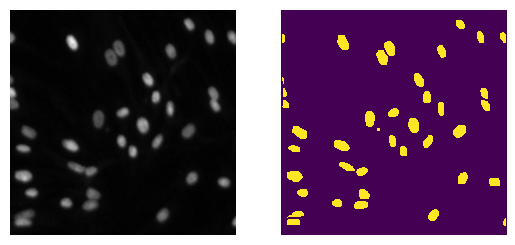

In [16]:
show_random_dataset_image(train_data)

If you visualized many images, you will see that some of them are fairly large. What happens if we load them into memory and feed them to the mode? We might run out of memory.
Consequently, when training networks on images or volumes one has to be careful about the input sizes. Also, for training in batches, i.e. feeding multiple images to the network at once, all images in the batch have to be of the same size. Hence all images need to be cropped or rescaled to the same size.

For this exercise we implement a class that will apply a transformation `random crop`. Notice that we apply it to images and masks simultaneously to make sure they correspond despite the randomness.

In case anybody is wondering why we have to bother to write a whole class for it instead of simply cropping the images directly in the dataset: we want to keep the code modular. We want to write one dataset object, and then we can try all the possible transforms with this one dataset. Similarly, we want to write one `RandomCrop` transform object, and then we can reuse it for any other image datasets we night have in the future.

In [17]:
class RandomCrop(object):
    """Crop randomly the input image and the output mask"""
    def __init__(self, crop_size):
        # check if the crop size is of a valid type
        assert isinstance(crop_size, (int, tuple, list))
        if isinstance(crop_size, int):
            # if the crop size is an integer, we use the same for both dimensions
            self.output_size = (crop_size, crop_size)
        else:
            assert len(crop_size) == 2
            self.crop_size = crop_size

    # this function makes our class callable
    def __call__(self, sample):
        # we need to crop both input and mask at the same time
        assert len(sample) == 2
        image, mask = sample
        # the first dimension is channels, then width, then height
        w, h = image.shape[1:]
        new_w, new_h = self.output_size
        # choose a random place to crop
        top = np.random.randint(0, h - new_h) if h - new_h > 0 else 0
        left = np.random.randint(0, w - new_w) if w - new_w > 0 else 0
        # crop and return
        image = image[:, left: left + new_w, top: top + new_h]
        mask = mask[:, left: left + new_w, top: top + new_h]
        return image, mask

PS: PyTorch already has quite a bunch of all possible data transforms, so if you need one, check [here](https://pytorch.org/vision/stable/transforms.html).

In [18]:
train_data = NucleiDataset(TRAIN_DATA_PATH, RandomCrop(256))
train_loader = DataLoader(train_data, batch_size=5, shuffle=True)

Image size is {torch.Size([256, 256])}


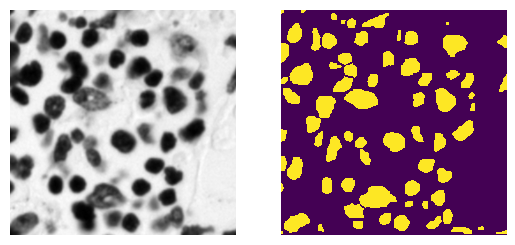

In [19]:
show_random_dataset_image(train_data)

And the same for the validation data:

In [20]:
VAL_DATA_PATH = os.path.join(data_dir, 'nuclei_val_data')
val_data = NucleiDataset(VAL_DATA_PATH, RandomCrop(256))
val_loader = DataLoader(val_data, batch_size=5)

Image size is {torch.Size([256, 256])}


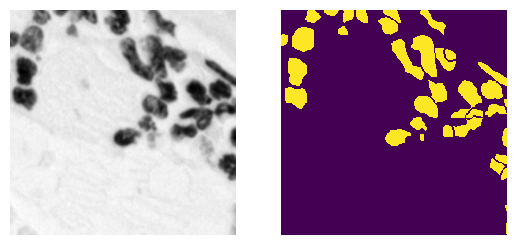

In [21]:
show_random_dataset_image(val_data)

## The model: U-net

Now we need to define the architecture of the model to use. This time we will use a [U-Net](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/) that has proven to steadily outperform the other architectures in segmenting biological and medical images.

The image of the model precisely describes all the building blocks you need to use to create it. All of them can be found in the list of PyTorch layers (modules) [here](https://pytorch.org/docs/stable/nn.html#convolution-layers).

The U-net has an encoder-decoder structure:
In the encoder pass, the input image is successively downsampled via max-pooling. In the decoder pass it is upsampled again via transposed convolutions.
In adddition, it has skip connections, that bridge the output from an encoder to the corresponding decoder.

In [22]:
class UNet(nn.Module):
    """ UNet implementation
    Arguments:
      in_channels: number of input channels
      out_channels: number of output channels
      final_activation: activation applied to the network output
    """

    # _conv_block and _upsampler are just helper functions to
    # construct the model.
    # encapsulating them like so also makes it easy to re-use
    # the model implementation with different architecture elements

    # Convolutional block for single layer of the decoder / encoder
    # we apply to 2d convolutions with relu activation
    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                             nn.ReLU(),
                             nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                             nn.ReLU())


    # upsampling via transposed 2d convolutions
    def _upsampler(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels,
                                kernel_size=2, stride=2)

    def __init__(self, in_channels=1, out_channels=1,
                 final_activation=None):
        super().__init__()

        # the depth (= number of encoder / decoder levels) is
        # hard-coded to 4
        self.depth = 4

        # the final activation must either be None or a Module
        if final_activation is not None:
            assert isinstance(final_activation, nn.Module), "Activation must be torch module"

        # all lists of conv layers (or other nn.Modules with parameters) must be wraped
        # itnto a nn.ModuleList

        # modules of the encoder path
        self.encoder = nn.ModuleList([self._conv_block(in_channels, 16),
                                      self._conv_block(16, 32),
                                      self._conv_block(32, 64),
                                      self._conv_block(64, 128)])
        # the base convolution block
        self.base = self._conv_block(128, 256)
        # modules of the decoder path
        self.decoder = nn.ModuleList([self._conv_block(256, 128),
                                      self._conv_block(128, 64),
                                      self._conv_block(64, 32),
                                      self._conv_block(32, 16)])

        # the pooling layers; we use 2x2 MaxPooling
        self.poolers = nn.ModuleList([nn.MaxPool2d(2) for _ in range(self.depth)])
        # the upsampling layers
        self.upsamplers = nn.ModuleList([self._upsampler(256, 128),
                                         self._upsampler(128, 64),
                                         self._upsampler(64, 32),
                                         self._upsampler(32, 16)])
        # output conv and activation
        # the output conv is not followed by a non-linearity, because we apply
        # activation afterwards
        self.out_conv = nn.Conv2d(16, out_channels, 1)
        self.activation = final_activation

    def forward(self, input):
        x = input
        # apply encoder path
        encoder_out = []
        for level in range(self.depth):
            x = self.encoder[level](x)
            encoder_out.append(x)
            x = self.poolers[level](x)

        # apply base
        x = self.base(x)

        # apply decoder path
        encoder_out = encoder_out[::-1]
        for level in range(self.depth):
            x = self.upsamplers[level](x)
            x = self.decoder[level](torch.cat((x, encoder_out[level]), dim=1))

        # apply output conv and activation (if given)
        x = self.out_conv(x)
        if self.activation is not None:
            x = self.activation(x)
        return x

## Loss and distance metrics

Next, we need to define the loss function - a metric that will tell us how close we are to the desired output. This metric should be differentiable, since it needs to be backpropagated. The are [multiple losses](https://lars76.github.io/2018/09/27/loss-functions-for-segmentation.html) we could use for the segmentation task.

Take a moment to think which one is better to use for our exercise. If you are not sure, don't forget that you can always google! Before you start implementing the loss yourself, take a look at the [losses](https://pytorch.org/docs/stable/nn.html#loss-functions) already implemented in PyTorch. You can also look for implementations on GitHub.

__TASK__: implement your loss (or take one from pytorch):

In [23]:
# TODO: your code here
loss = nn.MSELoss()

We will use the [Dice Coefficeint](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) to evaluate the network predictions.
We can use it for validation if we interpret set $a$ as predictions and $b$ as labels. It is often used to evaluate segmentations with sparse foreground, because the denominator normalizes by the number of foreground pixels.
The Dice Coefficient is closely related to Jaccard Index / Intersection over Union.

In [24]:
# sorensen dice coefficient implemented in torch
# the coefficient takes values in [0, 1], where 0 is
# the worst score, 1 is the best score
class DiceCoefficient(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    # the dice coefficient of two sets represented as vectors a, b ca be
    # computed as (2 *|a b| / (a^2 + b^2))
    def forward(self, prediction, target):
        intersection = (prediction * target).sum()
        denominator = (prediction * prediction).sum() + (target * target).sum()
        return (2 * intersection / denominator.clamp(min=self.eps))

## Training

Let's start with writing training and validation functions. __TASK__: fix in all the TODOs to make the function run. You can use the function from the classification exercises as a template.

In [25]:
# apply training for one epoch
def train(model, loader, optimizer, loss_function,
          epoch, log_interval=100, log_image_interval=20, logging=True):

    # set the model to train mode
    model.train()

    # iterate over the batches of this epoch
    for batch_id, (x, y) in enumerate(loader):
        # move input and target to the active device (either cpu or gpu)
        x, y = x.to(device), y.to(device)

        # zero the gradients for this iteration
        optimizer.zero_grad()


        # apply model, calculate loss and run backwards pass
        prediction = model(x)
        loss_value = loss_function(prediction, y[:, 0])
        loss_value.backward()
        optimizer.step()


        # log to console
        if log_interval > 0 and batch_id % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, batch_id * len(x),
                  len(loader.dataset),
                  100. * batch_id / len(loader), loss_value.item()))

       # log to tensorboard
        if logging ==True:
            step = epoch * len(loader) + batch_id
            wandb.log({"train_loss": loss_value.item()}, step=step)
            # check if we log images in this iteration
            if step % log_image_interval == 0:
                wandb.log({"input": wandb.Image(x[0].cpu().detach().numpy()),
                           "target": wandb.Image(y[0].cpu().detach().numpy()),
                           "prediction": wandb.Image(prediction[0].cpu().detach().numpy())}, step=step)

In [73]:
# run validation after training epoch
def validate(model, loader, loss_function, metric, step=None, logging=True):
    # set model to eval mode
    model.eval()


    # running loss and metric values
    val_loss = 0
    val_metric = 0

    # disable gradients during validation
    labels = []
    predictions = []

    with torch.no_grad():


      # iterate over validation loader and update loss and metric values
      for x, y in loader:
          x, y = x.to(device), y.to(device)
          # TODO: YOUR CODE HERE
          prediction = model(x)
          val_loss+=loss_function(prediction, y[:, 0])
          val_metric += metric(prediction[:,0], y[:, 0]).item()



      # normalize loss and metric
      val_loss /= len(loader)
      val_metric /= len(loader)

      if logging == True:
          assert step is not None, "Need to know the current step to log validation results"
          wandb.log({"val_loss": val_loss, "val_metric": val_metric}, step=step)
          # we always log the last validation images
          wandb.log({"val_input": wandb.Image(x[0].cpu().detach().numpy()),
                    "val_target": wandb.Image(y[0].cpu().detach().numpy()),
                    "val_prediction": wandb.Image(prediction[0].cpu().detach().numpy())}, step=step)

      print('\nValidate: Average loss: {:.4f}, Average Metric: {:.4f}\n'.format(val_loss, val_metric))


This time we will use GPU to train faster. Please make sure that your Notebook is running on GPU.

In [74]:
# check if we have  a gpu
if torch.cuda.is_available():
    print("GPU is available")
    device = torch.device("cuda")
else:
    print("GPU is not available")
    device = torch.device("cpu")

GPU is available


In [76]:
# build a default unet with sigmoid activation
# to normalize predictions to [0, 1]
net = UNet(1, 1, final_activation=nn.Sigmoid())
# move the model to GPU
net = net.to(device)

# use adam optimizer
optimizer=torch.optim.Adam(net.parameters())


# build the dice coefficient metric
metric = DiceCoefficient()

# initialize wandb logger
wandb.init()

# train for 25 epochs
# during the training you can inspect the
# predictions in the tensorboard
n_epochs = 25
for epoch in range(n_epochs):
    # train
    # TODO: YOUR CODE HERE
    train(net, train_loader, optimizer, loss,epoch)


    step = epoch * len(train_loader.dataset)
    # validate
    # TODO: YOUR CODE HERE
    validate(net, val_loader, loss, metric, step, logging=True)
wandb.finish()


val_loss,▁
val_metric,▁
val_loss,0.21818
val_metric,0.3185


Train Epoch: 0 [0/400 (0%)]	Loss: 0.250777


wandb: WARNING Tried to log to step 0 that is less than the current step 79. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 0 that is less than the current step 79. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.



Validate: Average loss: 0.1165, Average Metric: 0.0000

Train Epoch: 1 [0/400 (0%)]	Loss: 0.057819

Validate: Average loss: 0.1166, Average Metric: 0.0000

Train Epoch: 2 [0/400 (0%)]	Loss: 0.074942


wandb: WARNING Tried to log to step 160 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 160 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 161 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 162 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 163 that is less than the current step 400. Steps must be monotonically increasing, so this data will be ignored. See ht


Validate: Average loss: 0.1159, Average Metric: 0.0000

Train Epoch: 3 [0/400 (0%)]	Loss: 0.121909


wandb: WARNING Tried to log to step 240 that is less than the current step 800. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 240 that is less than the current step 800. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 241 that is less than the current step 800. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 242 that is less than the current step 800. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 243 that is less than the current step 800. Steps must be monotonically increasing, so this data will be ignored. See ht


Validate: Average loss: 0.1156, Average Metric: 0.0000

Train Epoch: 4 [0/400 (0%)]	Loss: 0.107004


wandb: WARNING Tried to log to step 320 that is less than the current step 1200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 320 that is less than the current step 1200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 321 that is less than the current step 1200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 322 that is less than the current step 1200. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 323 that is less than the current step 1200. Steps must be monotonically increasing, so this data will be ignored. S


Validate: Average loss: 0.1169, Average Metric: 0.0000

Train Epoch: 5 [0/400 (0%)]	Loss: 0.161801


wandb: WARNING Tried to log to step 400 that is less than the current step 1600. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 400 that is less than the current step 1600. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 401 that is less than the current step 1600. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 402 that is less than the current step 1600. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 403 that is less than the current step 1600. Steps must be monotonically increasing, so this data will be ignored. S


Validate: Average loss: 0.1160, Average Metric: 0.0000

Train Epoch: 6 [0/400 (0%)]	Loss: 0.169943


wandb: WARNING Tried to log to step 480 that is less than the current step 2000. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 480 that is less than the current step 2000. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 481 that is less than the current step 2000. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 482 that is less than the current step 2000. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 483 that is less than the current step 2000. Steps must be monotonically increasing, so this data will be ignored. S

KeyboardInterrupt: 

## Exercises

1. Implement and compare at least 2 of the following architecture variants of the U-Net:
    * use [Dropout](https://pytorch.org/docs/stable/nn.html#dropout-layers) in the decoder path
    * use [BatchNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d) to normalize layer inputs
    * use [GroupNorm](https://pytorch.org/docs/stable/nn.html#torch.nn.GroupNorm) to normalize convolutional group inputs
    * use [ELU-Activations](https://pytorch.org/docs/stable/nn.html#torch.nn.ELU) instead of ReLU-Activations

2. Use the Dice coefficient as loss function. Before we only used it for validation, but it is differentiable and can thus also be used as loss. Compare to the results from exercise 2.
Hint: The optimizer we use finds minima of the loss, but the minimal value for the Dice coefficient corresponds to a bad segmentation. How do we need to change the Dice coefficient to use it as loss nonetheless?

3. Add one more layer to the U-net model (currently it has 4). Compare the results.

## Advanced Exercises

1. Write your own data transform (e.g., RandomRotate)